In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import csv
from scipy.stats import pearsonr
import glob
import networkx as nx
from sklearn.cluster import SpectralClustering

In [13]:
def get_domain_df(data_csv):
    data = []
    all_langs = set()
    with open(data_csv, 'r') as file:
        csv_reader = csv.reader(file, delimiter=',')
        for row in csv_reader:
            if row[0] == '':
                continue
            l1 = row[1]
            l2 = row[2]
            all_langs.add(l1)
            all_langs.add(l2)
            alignment = float(row[3])
            w1 = row[4]
            w2 = row[5]
            domain = row[16]
            data.append(dict(l1=l1, 
                             l2=l2, 
                             alignment=alignment, 
                             w1=w1, 
                             w2=w2, 
                             domain=domain))

    lin_data = []
    files = glob.glob('../compute-alignment/w=*')
    for fn in files:
        with open(fn, 'r') as file:
            langs = fn.replace('../compute-alignment/w=', '').split('.')[0].split('-')
            l1, l2 = langs
            csv_reader = csv.reader(file, delimiter=',')
            for row in csv_reader:
                if row[0] == 'l1':
                    continue
                w1 = row[2]
                w2 = row[3]
                alignment = float(row[4])
                lin_data.append(dict(l1=l1, 
                                     l2=l2,
                                     w1=w1,
                                     w2=w2,
                                     linear_alignment=alignment))

    lin_df = pd.DataFrame(lin_data)

    df = pd.DataFrame(data)

    df = pd.merge(df, lin_df, how='left', on=['l1', 'l2', 'w1', 'w2'])
    df = df[df['linear_alignment'].notnull()]
#     df = df.groupby('domain').mean()
#     df = df.sort_values(by='alignment')

#     df = df.sort_values(by='linear_alignment')
    
    return df, all_langs

lang_map = dict()
with open('data/distances/FAIR_languages_glotto_xdid.csv', 'r') as file:
    csv_reader = csv.reader(file, delimiter=',')
    for row in csv_reader: 
        if row[0] == 'Language':
            continue
        full = row[0]
        short = row[8]
        lang_map[short] = full

In [55]:
df, all_langs = get_domain_df('../alignments-nel-wiki-trl.csv')

In [56]:
all_langs = list(all_langs)
df_lang = df.groupby(['l1', 'l2']).mean().reset_index()
df_lang

,l1,l2,alignment,linear_alignment
0,ab,ar,0.090083,-0.003411
1,ab,ce,0.065416,-0.002589
2,ab,lez,0.117368,-0.002039
3,ab,zh,0.020498,-0.000403
4,ar,zh,0.195731,-0.003098
...,...,...,...,...
2388,xal,lez,0.032507,-0.002082
2389,xal,ml,0.075671,-0.003545
2390,xal,ta,0.063401,-0.003546
2391,xal,te,0.050945,-0.003313


In [57]:
G = nx.Graph()
for lang in all_langs:
    G.add_node(lang_map[lang])

In [58]:
n = len(all_langs)
dists = np.zeros((n, n))
for i, row in df_lang.iterrows():
    l1, l2 = row['l1'], row['l2']
    alignment = row['linear_alignment']
    i1, i2 = all_langs.index(l1), all_langs.index(l1)
    dists[i1, i2] = alignment
    dists[i2, i1] = alignment
    G.add_edge(lang_map[l1], lang_map[l2], weight=alignment)
    
max_val = dists.max()
dists[dists != 0] = max_val - dists[dists!=0]

In [59]:
pos = nx.spring_layout(G, k=0.3, iterations=300)

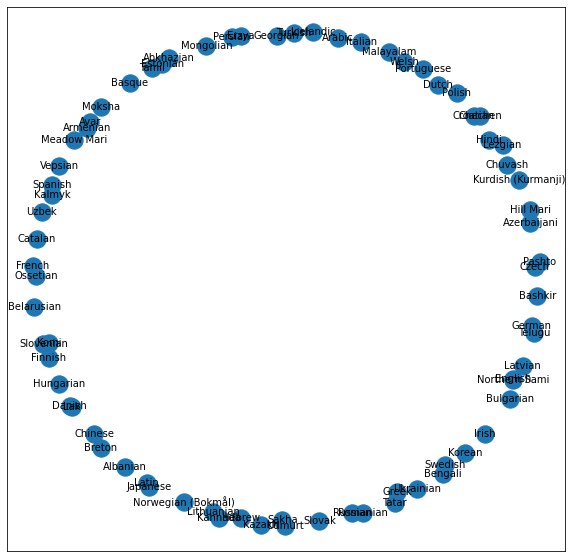

In [60]:
plt.rcParams["figure.figsize"] = (10, 10)
nx.draw_networkx_nodes(G, pos=pos, nodelist=G.nodes(), cmap='Pastel2')
nx.draw_networkx_labels(G, pos=pos, font_size=10);

In [61]:
n_clusters = 10
clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed').fit(dists)
print(clustering.labels_)

[4 2 3 4 2 2 3 3 2 9 2 4 3 2 2 7 2 3 7 8 3 7 2 0 2 1 2 2 3 2 2 0 7 6 4 3 2
 0 1 0 2 2 6 5 3 5 2 2 2 2 8 6 2 2 3 2 2 2 1 0 2 2 2 9 2 2 1 0 7 4 3 3 6 8]


/Users/keirp/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [62]:
for cluster in range(n_clusters):
    print(f'Cluster {cluster}:')
    for c, lang in zip(clustering.labels_, all_langs):
        if c == cluster:
            print(f'  {lang_map[lang]}')

Cluster 0:
  Uzbek
  Icelandic
  Tamil
  Czech
  Hindi
  Moksha
Cluster 1:
  Tatar
  Greek
  Albanian
  Avar
Cluster 2:
  Lezgian
  Pashto
  Azerbaijani
  Mongolian
  Norwegian (Bokmål)
  Polish
  German
  Ossetian
  Hungarian
  Kurdish (Kurmanji)
  Latin
  Turkish
  Hebrew
  Bengali
  Kalmyk
  Dutch
  Swedish
  Malayalam
  Chuvash
  Erzya
  Persian
  Northern Sami
  Sakha
  Slovenian
  Belarusian
  Russian
  Spanish
  Komi
  Kannada
  French
  Abkhazian
Cluster 3:
  Lak
  Welsh
  Breton
  Italian
  Meadow Mari
  Chinese
  Irish
  Chechen
  Latvian
  Danish
  Bulgarian
  Udmurt
Cluster 4:
  Korean
  Georgian
  Slovak
  Arabic
  Kazakh
Cluster 5:
  Ukrainian
  Vepsian
Cluster 6:
  Armenian
  Finnish
  Romanian
  Catalan
Cluster 7:
  Estonian
  Japanese
  English
  Croatian
  Telugu
Cluster 8:
  Bashkir
  Portuguese
  Basque
Cluster 9:
  Lithuanian
  Hill Mari
